In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

#importing
"""
Link to the kaggle dataset
https://www.kaggle.com/datasets/pablote/nba-enhanced-stats?select=2012-18_playerBoxScore.csv
"""
nba_player_stats_2016_2017 = pd.read_csv("2016-17_playerBoxScore.csv")
#nba_player_stats_2017_2018 = pd.read_csv("2017-18_playerBoxScore.csv")
nba_player_stats_2016_2017.head()

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2016-10-25,08:00,Regular,Porziņģis,Kristaps,NY,East,Atlantic,Away,Loss,...,0.5,4,3,7,CLE,East,Central,Home,Win,0
1,2016-10-25,08:00,Regular,Rose,Derrick,NY,East,Atlantic,Away,Loss,...,1.0,2,1,3,CLE,East,Central,Home,Win,0
2,2016-10-25,08:00,Regular,Anthony,Carmelo,NY,East,Atlantic,Away,Loss,...,1.0,1,4,5,CLE,East,Central,Home,Win,0
3,2016-10-25,08:00,Regular,Lee,Courtney,NY,East,Atlantic,Away,Loss,...,0.0,1,2,3,CLE,East,Central,Home,Win,0
4,2016-10-25,08:00,Regular,Noah,Joakim,NY,East,Atlantic,Away,Loss,...,0.0,1,5,6,CLE,East,Central,Home,Win,0


Remodelling the dataset to prepare the training model, by removing categorical data



In [ ]:
mask = nba_player_stats_2016_2017.dtypes == object
categorical_cols = nba_player_stats_2016_2017.columns[mask]

df_cleaned = nba_player_stats_2016_2017.drop(columns=categorical_cols)
df_cleaned

,teamDayOff,playMin,playHeight,playWeight,playPTS,playAST,playTO,playSTL,playBLK,playPF,...,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,opptDayOff
0,0,33,85,231,16,0,2,1,2,5,...,5,3,0.60,6,3,0.5000,4,3,7,0
1,0,30,75,190,17,1,4,0,1,1,...,2,1,0.50,2,2,1.0000,2,1,3,0
2,0,30,80,230,19,3,4,1,0,5,...,4,1,0.25,2,2,1.0000,1,4,5,0
3,0,20,77,200,0,0,2,0,1,1,...,2,0,0.00,0,0,0.0000,1,2,3,0
4,0,20,83,232,0,3,1,1,0,1,...,0,0,0.00,0,0,0.0000,1,5,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26140,2,26,73,180,25,2,4,1,0,2,...,6,3,0.50,3,2,0.6667,0,4,4,1
26141,2,23,79,210,6,3,3,0,0,1,...,0,0,0.00,0,0,0.0000,0,4,4,1
26142,2,36,77,218,19,7,3,0,0,5,...,10,5,0.50,0,0,0.0000,0,7,7,1
26143,2,22,81,220,11,2,0,1,0,1,...,0,0,0.00,5,1,0.2000,1,1,2,1


Removing the outliers that might negatively affect the model

In [ ]:
print("Original length of the dataset: ", len(df_cleaned))
#Since I cannot remove both data types at the same time I split it in two
fields = df_cleaned.dtypes == int
categorical_cols = df_cleaned.columns[fields]
#categorical_cols contains the name of each int datatypes
for field in categorical_cols:
  Q1 = df_cleaned[field].quantile(0.25)
  Q3 = df_cleaned[field].quantile(0.75)
  IQR = Q3 - Q1
  threshold = 1.5
  outliers = df_cleaned[(df_cleaned[field] < Q1 - threshold * IQR) | (df_cleaned[field] > Q3 + threshold * IQR)]
  #I print out the different outliers
  #print(field)
  #print(outliers)
  df_cleaned = df_cleaned.drop(outliers.index)

#This is for removing the outliers for the float type
fields = df_cleaned.dtypes == float
categorical_cols = df_cleaned.columns[fields]
for field in categorical_cols:
  Q1 = df_cleaned[field].quantile(0.25)
  Q3 = df_cleaned[field].quantile(0.75)
  IQR = Q3 - Q1
  threshold = 1.5
  outliers = df_cleaned[(df_cleaned[field] < Q1 - threshold * IQR) | (df_cleaned[field] > Q3 + threshold * IQR)]
  #I print out the different outliers
  #print(field)
  #print(outliers)
  df_cleaned = df_cleaned.drop(outliers.index)
print("New length of the dataset after removing the outliers: ", len(df_cleaned))

Original length of the dataset:  26145
New length of the dataset after removing the outliers:  12841


Using **Featured selections** to find the most impacting fields of the dataset

In [ ]:
"""
Answer - Question 3
"""
import statsmodels.api as sm
import pandas as pd

# Backward Elimination
df_cleaned2 = df_cleaned.copy()
# =============================================================================
y = df_cleaned['playPTS']
X = df_cleaned.drop('playPTS', axis=1)
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()

    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)
X_1

['playAST', 'play2PM', 'play3PM', 'playFTM']


,const,playAST,play2PM,play3PM,playFTM
3,1.0,0,0,0,0
4,1.0,3,0,0,0
5,1.0,2,0,2,2
7,1.0,1,1,0,0
8,1.0,1,1,0,0
...,...,...,...,...,...
26130,1.0,5,4,0,0
26136,1.0,2,1,0,1
26138,1.0,3,2,2,0
26141,1.0,3,3,0,0


Training my Linear regression model with train_test_split and showing the accuracy of the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#selecting the most impactful features
X_data = df_cleaned[selected_features_BE]

#splitting the dataset
train_X, test_X, train_y, test_y = train_test_split(X_data, y,
                                                    #train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=42)

# making a linear progression
LR = LinearRegression()

error_df = list()

LR.fit(train_X, train_y)
y_train_pred = LR.predict(train_X)
y_test_pred = LR.predict(test_X)

error_df.append(pd.Series({'train': mean_squared_error(train_y, y_train_pred),
                           'test': mean_squared_error(test_y, y_test_pred)},
                           name='no enc'))
print(f"Accuracy of the linear regression model: {LR.score(test_X,test_y)}")
error_df = pd.concat(error_df, axis=1)
error_df

Accuracy of the linear regression model: 0.9999879147449082


,no enc
train,1.698524e-29
test,2.595380e-04


Visualisation of the model

[Text(0.5, 0, 'Points truth'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, 'Nba, player points Predictions vs Truth')]

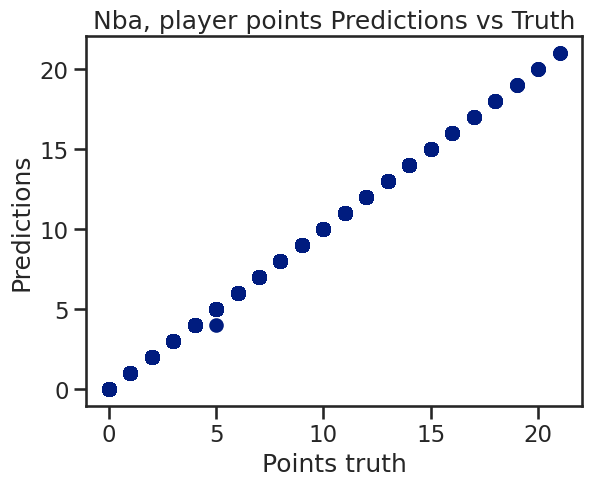

In [ ]:
import seaborn as sns
import numpy as np


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()

ax.scatter(test_y, y_test_pred)

ax.set(xlabel='Points truth', ylabel='Predictions',title='Nba, player points Predictions vs Truth')

**Changing the parameter for the linear prediction, by trying to predict player 3 point %**



In [ ]:
df_cleaned2
y = df_cleaned2['play3P%']
X = df_cleaned2.drop('play3P%', axis=1)
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()

    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
three_point_selected_features_BE = cols
print(three_point_selected_features_BE)
X_1

['playMin', 'playWeight', 'playAST', 'playBLK', 'playFGA', 'playFGM', 'playFG%', 'play2PA', 'play2PM', 'play2P%', 'play3PA', 'play3PM', 'playORB', 'playDRB', 'playTRB']


,const,playMin,playWeight,playAST,playBLK,playFGA,playFGM,playFG%,play2PA,play2PM,play2P%,play3PA,play3PM,playORB,playDRB,playTRB
3,1.0,20,200,0,1,5,0,0.0000,3,0,0.0000,2,0,1,2,3
4,1.0,20,232,3,0,1,0,0.0000,1,0,0.0000,0,0,1,5,6
5,1.0,26,185,2,0,7,2,0.2857,4,0,0.0000,3,2,1,5,6
7,1.0,17,225,1,0,4,1,0.2500,4,1,0.2500,0,0,0,1,1
8,1.0,15,224,1,2,3,1,0.3333,1,1,1.0000,2,0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26130,1.0,16,180,5,0,11,4,0.3636,9,4,0.4444,2,0,1,2,3
26136,1.0,14,191,2,0,3,1,0.3333,2,1,0.5000,1,0,1,0,1
26138,1.0,37,209,3,0,10,4,0.4000,5,2,0.4000,5,2,2,2,4
26141,1.0,23,210,3,0,8,3,0.3750,8,3,0.3750,0,0,0,4,4


Making the linear regression model

Accuracy of the linear regression model: 0.8631218279440195
         no enc
train  0.005697
test   0.005721


(-0.22737785432319582, 0.7126514295294403)

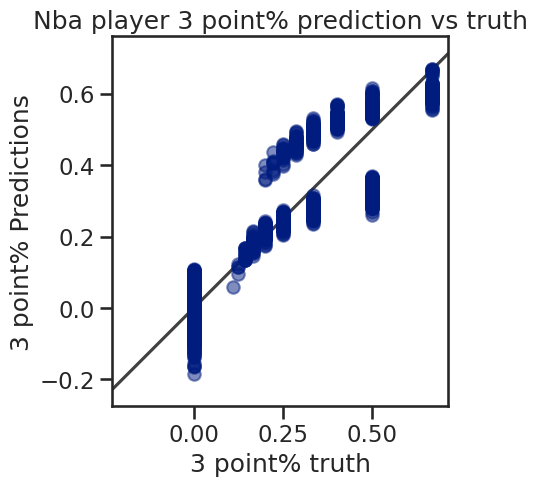

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#selecting the most impactful features
X_data = df_cleaned2[three_point_selected_features_BE]

#splitting the dataset
train_X, test_X, train_y, test_y = train_test_split(X_data, y,
                                                    #train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=42)

# making a linear progression
LR = LinearRegression()

error_df = list()

LR.fit(train_X, train_y)
y_train_pred = LR.predict(train_X)
y_test_pred = LR.predict(test_X)

error_df.append(pd.Series({'train': mean_squared_error(train_y, y_train_pred),
                           'test': mean_squared_error(test_y, y_test_pred)},
                           name='no enc'))
print(f"Accuracy of the linear regression model: {LR.score(test_X,test_y)}")
error_df = pd.concat(error_df, axis=1)
print(error_df)

#Showing the plot
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
ax.scatter(test_y, y_test_pred, alpha=.5)

ax.set(xlabel='3 point% truth', ylabel='3 point% Predictions',title='Nba player 3 point% prediction vs truth');
# add a diagonal line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)